# Introduction

This notebook documents the first approach to preprocessing utilizing a tweet specific processing package along with nltk to create the dataset input for modeling.

Additionally this notebook has iterations upon the dataset where feature engineering was applied to denote brand (Apple versus Google) and type of tweet subject (product, service, app, none) that was appended to the sparse matrix for the vocabulary utilized in each tweet.

Note: this is a scratch notebook, but necessary to understand the full scope of iterations done in the modeling process

## Summary

### Business Case

#### Background
A marketing agency specializing in brand representation at large scale events/festivals (like SXSW) is building an internal tool to help manage social presence of major brands.

This project is the first step in building a base model to fuel auto-responses and amplification of positive tweets for their clients that will aid in social presence and positive interactions with the brand.

The agency invested in manually labelling these tweets positive/negative/neutral to support building the first model with the intention to build this dataset and predictiveness over time.

#### Metrics
Beyond the foundational goal of building a model with accuracy above a random guess, **the main goal in mind is to accurately label _positive tweets_; thus the model iteration focuses on maximizing precision scores**. This minimizes False Positives where a negative or neutral tweet is classified as positive and company amplifies promoting something that attendees view negatively about a brand. A False Positive would be more harmful than a False Negative where a positive tweet is classified as negative, and company misses opportunity to amplify messaging around something that customers view positively.

### Base Dataset Visualizations
- [Brand Tweet Count](#DV_1)
- [Sentiment Tweet Count](#DV_2)
- [Brand Tweet Count by Sentiment](#DV_3)
- [Sentiment Tweet Count by Brand](#DV_4)



### Models

**Phase 1: Data Version 1 and Baseline Testing**
- [Model 1 - Naive Bayes + CountVec](#Model_1)
- [Model 2 - Naive Bayes + TF-IDF](#Model_2)
- [Model 3 - Random Forest + TF-IDF](#Model_3)

**Phase 2: Data Version 2 + 3 and Model Retesting**
- [Model 4 - Data Version 2 Naive Bayes + TF-IDF](#Model_4)
- [Model 5 - Data Version 3 Naive Bayes + TF-IDF](#Model_5)
- [Model 6 - Data Version 3 Random Forest + TF-IDF](#Model_6)

## Conclusion and Next Steps

There was limited ability to get movement in model score results beyond the baseline in regards to accuracy and precision metrics.

I recognized that preprocessing decisions may have played a part in this. Thus Preprocessing_V2 notebook in this repository, the most updated approach, was created. This V2 notebook applies the SpaCy package in the preprocessing step and leads to improvement in the goal metric of precision using SVC.

### Imports

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing tweets
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, f1_score

# Vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# import file
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')

In [3]:
# Preview file 
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [4]:
# Overview file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


### Functions

In [5]:
# Thanks to my Flatiron DS teacher, Lindsey Berlin!
def classify_vectorized_text(vectorizer, classifier, X_train, X_test, y_train, y_test):
    '''
    Fit and transform text data using the provided vectorizer, then fit and 
    predict with the provided classifier, in order to see the resulting
    accuracy score and confusion matrix
    For the Xtrain, Xtest, ytrain, ytest, expect the output of an
    sklearn train/test split
    -
    Inputs:
    vectorizer: an instantiated sklearn vectorizer
    classifier: an instantiated sklearn classifier
    X_train: training input data
    X_test: testing input data
    y_train: training true result
    y_test: testing true result
    -
    Outputs: 
    train_preds: predicted results for the train set
    test_preds: predicted results for the test set
    '''

    X_train_transformed = vectorizer.fit_transform(X_train) #learning corpus of training data (holistic)
    X_test_transformed = vectorizer.transform(X_test) # new words only in test set won't impact

    classifier.fit(X_train_transformed, y_train)

    train_preds = classifier.predict(X_train_transformed)
    test_preds = classifier.predict(X_test_transformed)

    print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
    print(f'Precision:{precision_score(y_test, test_preds)}')
    print(f'F1 Score:{f1_score(y_test, test_preds)}')
    plot_confusion_matrix(classifier, X_test_transformed, y_test,
                          values_format=".4g")  # to make numbers readable
    plt.show()

    return(train_preds, test_preds)

### Data Exploration and Early Feature Engineering

Checked:
- value counts
- nulls
- class balance

Created:
- brand_directed_at
- num_brand_directed_at
- type_directed_at
- num_type_directed_at

In [6]:
# Value counts exploration
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [7]:
# Fill nulls
df['emotion_in_tweet_is_directed_at'].fillna('None', inplace=True)

In [8]:
# Recheck
df['emotion_in_tweet_is_directed_at'].value_counts()

None                               5802
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [9]:
# Create feature to simplify 'emotion' data to brand level (Apple, Google, or None)
df['brand_directed_at'] = df['emotion_in_tweet_is_directed_at'].map({'iPad': 'Apple',
                                                                    'Apple':'Apple',
                                                                    'iPad or iPhone App': 'Apple',
                                                                    'Google': 'Google', 
                                                                    'iPhone':'Apple',
                                                                    'Other Google product or service': 'Google',
                                                                    'Android App': 'Google', 
                                                                    'Android': 'Google',
                                                                    'Other Apple product or service':'Apple',
                                                                    'None':'None'})

In [10]:
df['brand_directed_at'].value_counts()

None      5802
Apple     2409
Google     882
Name: brand_directed_at, dtype: int64

In [11]:
# Create numerical version for model testing
df['num_brand_directed_at'] = df['brand_directed_at'].map({'None': 0,
                                                           'Apple': 1,
                                                           'Google': 2})

In [12]:
# Create feature to translate 'emotion' data to type level (Product, Brand, App, Service, None)
df['type_directed_at'] = df['emotion_in_tweet_is_directed_at'].map({'iPad': 'Product',
                                                                    'Apple':'Brand',
                                                                    'iPad or iPhone App': 'App',
                                                                    'Google': 'Brand', 
                                                                    'iPhone':'Product',
                                                                    'Other Google product or service': 'Service',
                                                                    'Android App': 'App', 
                                                                    'Android': 'Product',
                                                                    'Other Apple product or service':'Service',
                                                                    'None':'None'})

In [13]:
# Create numerical version for model testing
df['num_type_directed_at'] = df['type_directed_at'].map({'None': 0,
                                                         'Product': 1,
                                                         'Brand': 2,
                                                         'App': 3,
                                                         'Service': 4})

In [14]:
# Value counts exploration
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [15]:
# Filter down emotions to Neutral
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({"No emotion toward brand or product" : "Neutral",
                                                                                                                         "Positive emotion": "Positive",
                                                                                                                         "Negative emotion": "Negative",
                                                                                                                         "I can't tell": "Neutral"})

In [16]:
# 67/33 split (33% positive), class imbalance
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

Neutral     5545
Positive    2978
Negative     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [17]:
# Create target; Positive only - 32%
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({"Positive": 1,
                                                                             "Neutral": 0,
                                                                             "Negative": 0})

In [18]:
# Check work
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand_directed_at,num_brand_directed_at,type_directed_at,num_type_directed_at,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,1,Product,1,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,1,App,3,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,1,Product,1,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,1,App,3,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,2,Brand,2,1


In [19]:
# Check for nulls
df.isnull().sum()

tweet_text                                            1
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
brand_directed_at                                     0
num_brand_directed_at                                 0
type_directed_at                                      0
num_type_directed_at                                  0
target                                                0
dtype: int64

In [20]:
# Dropping null code was not performing, tracked down the individual row
df[df['tweet_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand_directed_at,num_brand_directed_at,type_directed_at,num_type_directed_at,target
6,NaN,None,Neutral,None,0,None,0,0


In [21]:
# Dropped row 6
df.drop(labels=6, axis=0, inplace=True)

In [22]:
# reset index post drop
df = df.reset_index(drop=True)

In [23]:
# Check current df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 8 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       9092 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9092 non-null object
brand_directed_at                                     9092 non-null object
num_brand_directed_at                                 9092 non-null int64
type_directed_at                                      9092 non-null object
num_type_directed_at                                  9092 non-null int64
target                                                9092 non-null int64
dtypes: int64(3), object(5)
memory usage: 568.4+ KB


### Base Dataset Visualization

<a id="DV_1"></a>

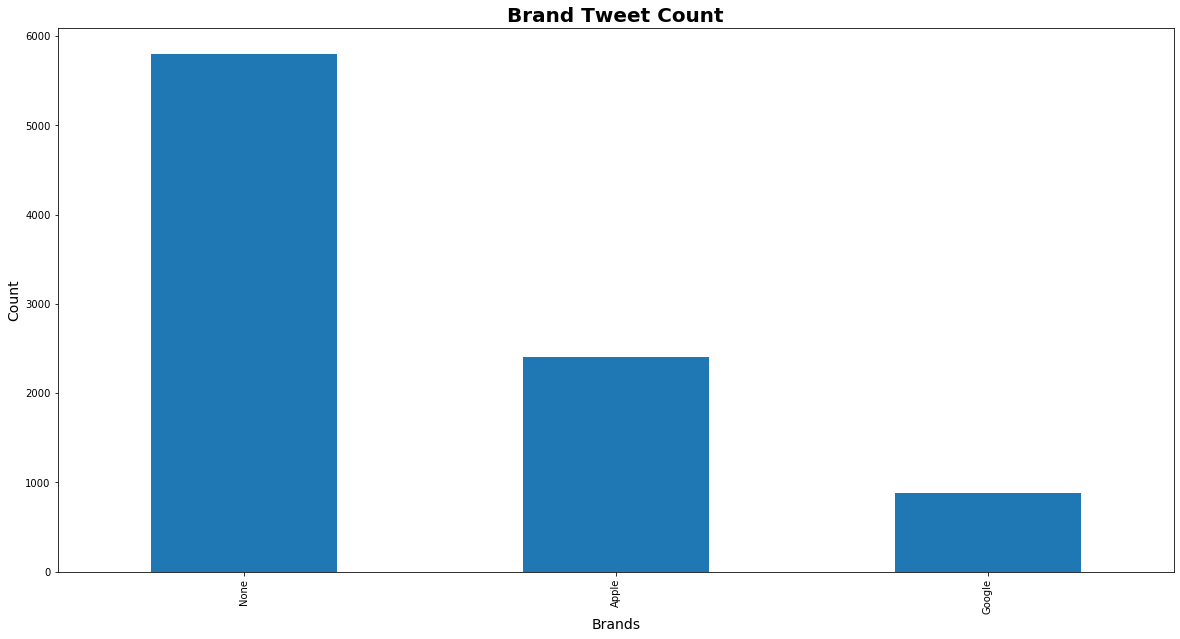

In [24]:
# Plot tweet count by Brand directed at
ax = df['brand_directed_at'].value_counts().plot(kind='bar',
                                                 figsize=(20,10))
ax.set_title("Brand Tweet Count", fontsize=20, fontweight="bold")
ax.set_xlabel("Brands", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
plt.savefig("images/1_brand_tweet_count")
plt.show()
# Many tweets shown to not be directed at a brand

<a id="DV_2"></a>

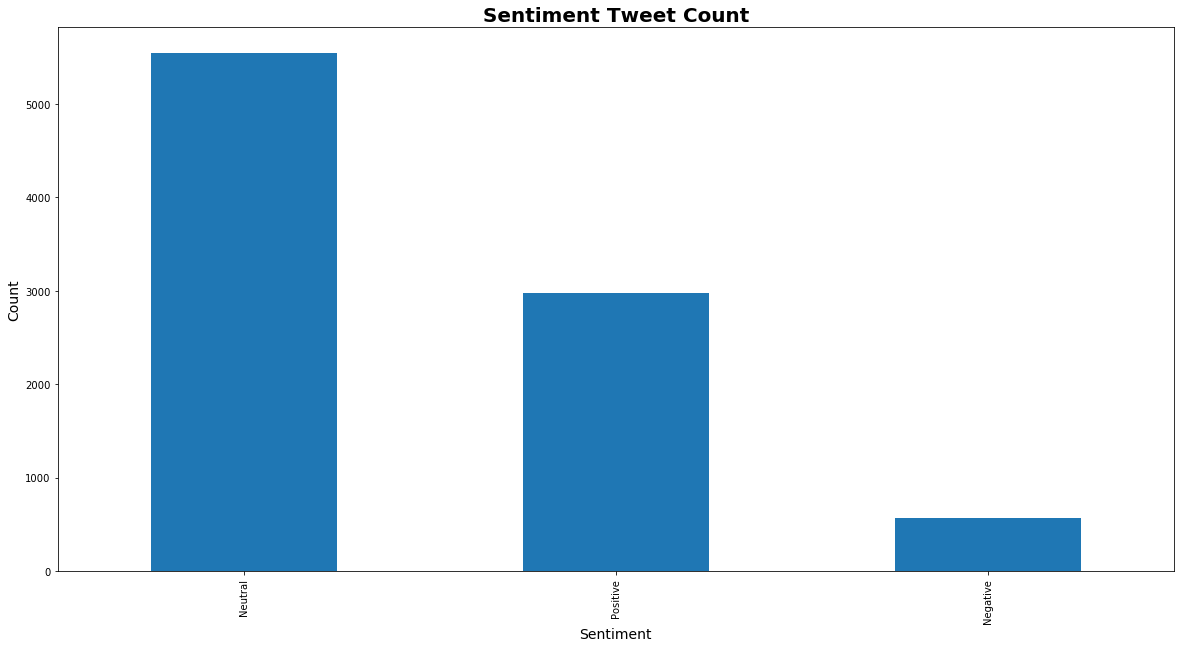

In [25]:
# Plot tweet count by emotion
ax = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().plot(kind='bar',
                                                 figsize=(20,10))
ax.set_title("Sentiment Tweet Count", fontsize=20, fontweight="bold")
ax.set_xlabel("Sentiment", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
plt.savefig("images/2_sentiment_tweet_count")
plt.show()
# Many tweets are neutral
# In modeling focus on classifying positive tweets

#### Explore Sentiment Counts

In [26]:
apple_sent_counts = df[df['brand_directed_at'] == 'Apple']['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
google_sent_counts = df[df['brand_directed_at'] == 'Google']['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

In [27]:
apple_sent_counts

Positive    1949
Negative     388
Neutral       72
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [28]:
google_sent_counts

Positive    723
Negative    131
Neutral      28
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

<a id="DV_3"></a>

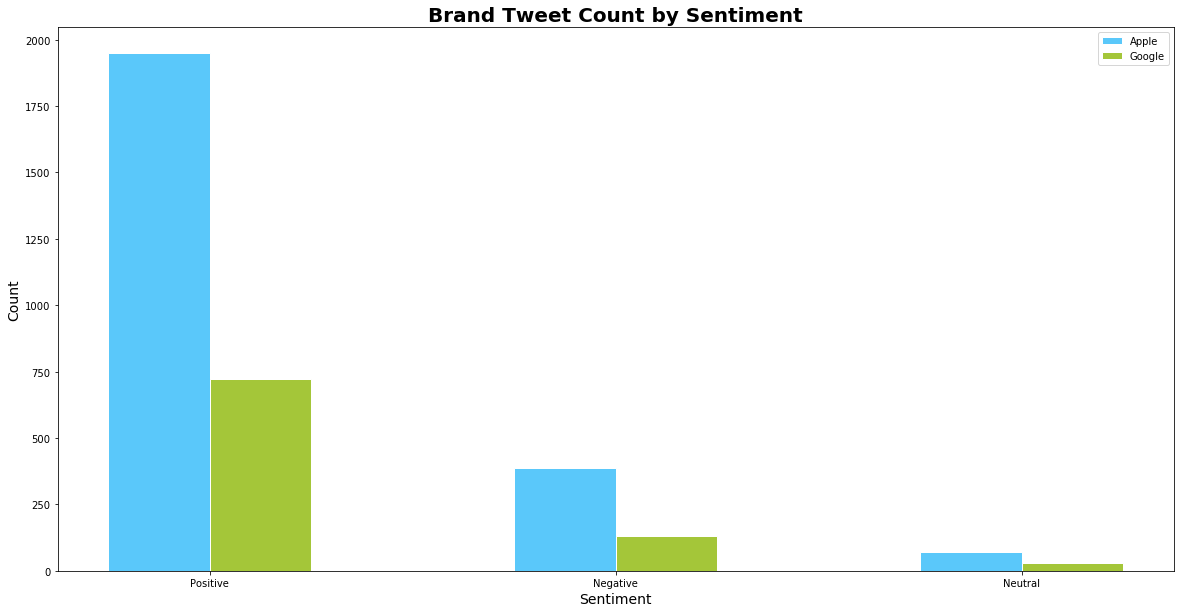

In [29]:
# Plot counts by Sentiment by Brand
plt.figure(figsize=(20, 10))

# set width of bars
barWidth = 0.25

# set heights of bars
bars1 = list(apple_sent_counts)
bars2 = list(google_sent_counts)
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#5ac8fa', width=barWidth, edgecolor='white', label='Apple')
plt.bar(r2, bars2, color='#a4c639', width=barWidth, edgecolor='white', label='Google')
 
# Add xticks on the middle of the group bars
plt.xlabel('Sentiment', fontsize=14)
plt.xticks([r + (barWidth/2) for r in range(len(bars1))], ['Positive', 'Negative', 'Neutral'])
plt.ylabel('Count', fontsize=14)

# Title
plt.title('Brand Tweet Count by Sentiment', fontsize=20, fontweight="bold")

# Create legend, Save, & Show graphic
plt.legend()
plt.savefig("images/3_brand_tweet_by_sentiment_count")
plt.show()

In [30]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product',
       'brand_directed_at', 'num_brand_directed_at', 'type_directed_at',
       'num_type_directed_at', 'target'],
      dtype='object')

In [31]:
pos_sent_counts = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive']['brand_directed_at'].value_counts()
neu_sent_counts = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative']['brand_directed_at'].value_counts()
neg_sent_counts = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Neutral']['brand_directed_at'].value_counts()

In [32]:
pos_sent_counts

Apple     1949
Google     723
None       306
Name: brand_directed_at, dtype: int64

In [33]:
neu_sent_counts

Apple     388
Google    131
None       51
Name: brand_directed_at, dtype: int64

In [34]:
neg_sent_counts = neg_sent_counts.sort_index()
neg_sent_counts

Apple       72
Google      28
None      5444
Name: brand_directed_at, dtype: int64

<a id="DV_4"></a>

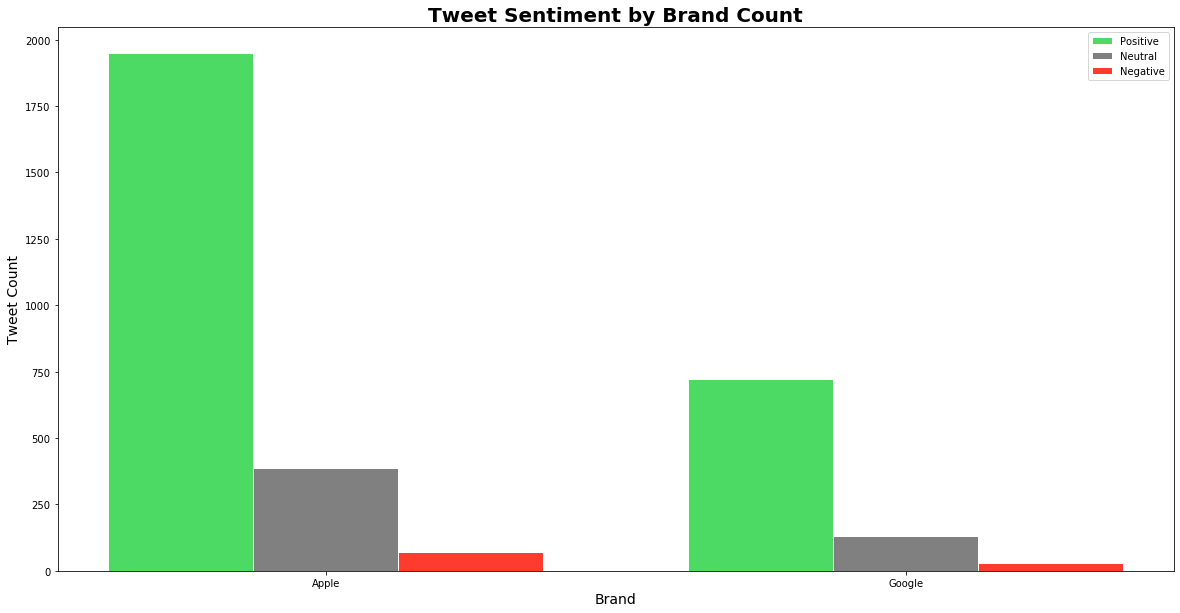

In [35]:
# Plot counts by Brand by Sentiment (remove tweets not directed at Brand)
plt.figure(figsize=(20, 10))

# set width of bars
barWidth = 0.25

# set heights of bars - Bars are sentiment
bars1 = list(pos_sent_counts[:2])
bars2 = list(neu_sent_counts[:2])
bars3 = list(neg_sent_counts[:2])
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#4cd964', width=barWidth, edgecolor='white', label='Positive')
plt.bar(r2, bars2, color='#808080', width=barWidth, edgecolor='white', label='Neutral')
plt.bar(r3, bars3, color='#ff3b30', width=barWidth, edgecolor='white', label='Negative')
 
# Add xticks on the middle of the group bars
plt.xlabel('Brand', fontsize=14)
plt.xticks([r + barWidth for r in range(len(bars1))], ['Apple', 'Google', 'None'])
plt.ylabel('Tweet Count', fontsize=14)

# Title
plt.title('Tweet Sentiment by Brand Count', fontsize=20, fontweight="bold")

# Create legend & Show graphic
plt.legend()
plt.savefig("images/4_tweet_sentiment_by_brand_count")
plt.show()

#### Create Target
- target (positive tweets versus netural/negative tweets) for classification model

In [36]:
# 67/33 split (33% positive), class imbalance
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

Neutral     5544
Positive    2978
Negative     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [37]:
# Create target; Positive only - 32%
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({"Positive": 1,
                                                                             "Neutral": 0,
                                                                             "Negative": 0})

### Preprocessing

Using preprocessor package (tweet specific) and nltk:
- remove URLs, mentions, HTML, punctuation
- remove stop words (including twitter operational lingo 'mention', 'rt', 'link', 'via')
- lower case
- tokenize tweets
- lemmatize tweets

Created 'clean_text' column for tweet text that has undergone the above preprocessing for use in modeling while preserving original 'tweet_text'

In [38]:
# Tweet preprocessor test
# Source: https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e
import preprocessor as p

In [39]:
p.clean(df['tweet_text'][0])

'. I have a G iPhone. After hrs tweeting at , it was dead! I need to upgrade. Plugin stations at .'

In [40]:
# Create new column for cleaned text - remove URLs, Mentions
df['clean_text'] = df['tweet_text'].apply(lambda x: p.clean(x))

# Lower case
df['clean_text'] = df['clean_text'].str.lower()

In [41]:
# Preview new 
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand_directed_at,num_brand_directed_at,type_directed_at,num_type_directed_at,target,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,1,Product,1,0,". i have a g iphone. after hrs tweeting at , i..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,1,App,3,1,know about ? awesome ipad/iphone app that you'...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,1,Product,1,1,can not wait for also. they should sale them d...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,1,App,3,0,i hope this year's festival isn't as crashy as...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,2,Brand,2,1,"great stuff on fri : marissa mayer (google), t..."


In [42]:
# Pull tweet with HTML &quot;
df['tweet_text'][9090]

'Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.'

In [43]:
# Test cleaning
html_ent_clean = re.compile('&.*?;')
re.sub(html_ent_clean, '', df['clean_text'][9090])

'some verizon iphone customers complained their time fell back an hour this weekend. of course they were the new yorkers who attended .'

In [44]:
# Clean 'clean_text' column of HTML
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(html_ent_clean, '',x))

In [45]:
# Check work
len(df[df['clean_text'].str.contains(html_ent_clean) == True])

0

In [46]:
# Remove punctuation
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'[^\w\s]', '', (x)))

In [47]:
# Check work 
df['clean_text'][9090]

'some verizon iphone customers complained their time fell back an hour this weekend of course they were the new yorkers who attended '

#### Remove stopwords

In [48]:
# Create stopwords list
twitter_ops = ['mention', 'rt', 'link', 'via'] # Twitter operational words not valueable, remove
stop_words = stopwords.words('english') + list(string.punctuation) + twitter_ops

In [49]:
# Remove stopwords in 'clean_text'
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(
    [word for word in x.split() if word.lower() not in (stop_words)]))

In [50]:
# Review clean_text
df['clean_text']

0       g iphone hrs tweeting dead need upgrade plugin...
1       know awesome ipadiphone app youll likely appre...
2                                          wait also sale
3        hope years festival isnt crashy years iphone app
4       great stuff fri marissa mayer google tim oreil...
                              ...                        
9087                                      ipad everywhere
9088    wave buzz interrupt regularly scheduled geek p...
9089    googles zeiger physician never reported potent...
9090    verizon iphone customers complained time fell ...
9091                    ___rt google tests checkin offers
Name: clean_text, Length: 9092, dtype: object

#### Tokenize

In [51]:
# Tokenize
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

df['clean_text'] = df['clean_text'].apply(lambda x: nltk.regexp_tokenize(x, pattern))

In [52]:
# Preview
df['clean_text']

0       [g, iphone, hrs, tweeting, dead, need, upgrade...
1       [know, awesome, ipadiphone, app, youll, likely...
2                                      [wait, also, sale]
3       [hope, years, festival, isnt, crashy, years, i...
4       [great, stuff, fri, marissa, mayer, google, ti...
                              ...                        
9087                                   [ipad, everywhere]
9088    [wave, buzz, interrupt, regularly, scheduled, ...
9089    [googles, zeiger, physician, never, reported, ...
9090    [verizon, iphone, customers, complained, time,...
9091                 [rt, google, tests, checkin, offers]
Name: clean_text, Length: 9092, dtype: object

#### Lemmatization

Chose lemmatization over stemming as stemming dropped e's from words like iphone

In [53]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

df['clean_text'] = df['clean_text'].apply(lemmatize_text)
# Source: https://stackoverflow.com/questions/59567357/lemmatize-tokenised-column-in-pandas

In [54]:
df['clean_text']

0       [g, iphone, hr, tweeting, dead, need, upgrade,...
1       [know, awesome, ipadiphone, app, youll, likely...
2                                      [wait, also, sale]
3       [hope, year, festival, isnt, crashy, year, iph...
4       [great, stuff, fri, marissa, mayer, google, ti...
                              ...                        
9087                                   [ipad, everywhere]
9088    [wave, buzz, interrupt, regularly, scheduled, ...
9089    [google, zeiger, physician, never, reported, p...
9090    [verizon, iphone, customer, complained, time, ...
9091                   [rt, google, test, checkin, offer]
Name: clean_text, Length: 9092, dtype: object

In [55]:
# Rejoin
df['clean_text'] = df['clean_text'].map(lambda x: ' '.join(x))

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 9 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       9092 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9092 non-null object
brand_directed_at                                     9092 non-null object
num_brand_directed_at                                 9092 non-null int64
type_directed_at                                      9092 non-null object
num_type_directed_at                                  9092 non-null int64
target                                                9092 non-null int64
clean_text                                            9092 non-null object
dtypes: int64(3), object(6)
memory usage: 639.4+ KB


In [57]:
# Average number of words in clean_text
num_words = df.clean_text.apply(lambda x: len(x.split()))
num_words.mean()

8.519247690277167

### Phase 1 Modeling

In [58]:
# Grabbing our inputs and target
X = df['clean_text']
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Model 1: Naive Bayes + CountVec<a id="Model_1"></a>

In [59]:
# Instantiating a count vectorizer
countvec = CountVectorizer()

Accuracy:0.7069951605807303
Precision:0.5766192733017378
F1 Score:0.5229226361031519


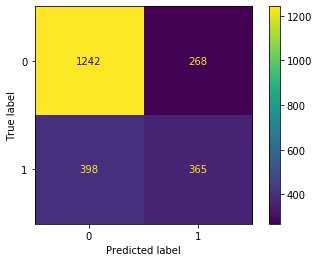

(array([0, 1, 1, ..., 1, 1, 0]), array([0, 0, 1, ..., 1, 0, 0]))

In [60]:
# Trying Naive Bayes
nb = MultinomialNB()

classify_vectorized_text(countvec, nb, X_train, X_test, y_train, y_test)
#0.58 precision score

#### Model 2: Naive Bayes + TF-IDF<a id="Model_2"></a>

In [61]:
# Instantiating the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Training on the train set, then transforming the train set
tfidf_train = tfidf.fit_transform(X_train)
# Transforming the test set
tfidf_test = tfidf.transform(X_test)

Accuracy:0.7109546854377474
Precision:0.6977611940298507
F1 Score:0.3627546071774976


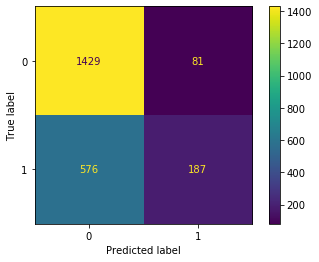

(array([0, 0, 0, ..., 0, 1, 0]), array([0, 0, 1, ..., 0, 0, 0]))

In [62]:
# More Naive Bayes, but with tfidf
nb_tfidf = MultinomialNB()

classify_vectorized_text(tfidf, nb_tfidf, X_train, X_test, y_train, y_test)
# Precision up by 0.12 - significant
# Accuracy also higher
# F1 down by .2 meaning recall is meaningfully lower
# Stick with TF-IDF

#### Model 3: Random Forest + TF-IDF<a id="Model_3"></a>

Accuracy:0.722833260008799
Precision:0.6095551894563427
F1 Score:0.5401459854014599


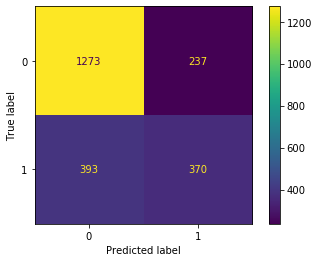

(array([0, 0, 1, ..., 1, 1, 0]), array([0, 0, 0, ..., 1, 0, 0]))

In [63]:
# Try RandomForest with class balance (not used in previous models)
rfc = RandomForestClassifier(class_weight='balanced')

classify_vectorized_text(tfidf, rfc, X_train, X_test, y_train, y_test)
# Precision lower

## Phase 2: Modeling with additional features

Bring in features engineered earlier in the notebook regarding brand and type

### Dataset creation 
TF-IDF + appending num_brand and num_type fields

In [64]:
# Grabbing our inputs and target
X = df[['clean_text', 'num_brand_directed_at', 'num_type_directed_at']]
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### TF-IDF application

In [65]:
# Instantiating the TF-IDF vectorizer; labeled as 2 to differentiate instance
tfidf2 = TfidfVectorizer(max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

In [66]:
X_train_transformed = tfidf2.fit_transform(X_train['clean_text'])
X_test_transformed = tfidf2.transform(X_test['clean_text'])

In [67]:
# Create X_train with appended columns
# X_train text vectorizing
X_train_tfidfvect_text_df = pd.DataFrame(X_train_transformed.toarray(), columns=tfidf2.get_feature_names())

In [68]:
# Preview
X_train_tfidfvect_text_df.head()

,aapl,ab,abc,ability,able,absolutely,absolutley,abt,academy,acc,...,zazzle,zinio,zip,zms,zombie,zomg,zone,zoom,zuckerberg,zynga
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# Append emotion in tweet directed at to vectorized X_train clean text
X_train_full = pd.merge(left=X_train_tfidfvect_text_df, right=X[['num_brand_directed_at', 'num_type_directed_at']],
                        how='left', left_index=True, right_index=True)

In [70]:
# Shape check X_train
X_train_full.shape

(6819, 3711)

In [71]:
# Shape check y_train
y_train.shape

(6819,)

In [72]:
# Create X_test with appended columns
X_test_tfidfvect_text_df = pd.DataFrame(X_test_transformed.toarray(), columns=tfidf2.get_feature_names())

In [73]:
# Append emotion in tweet directed at to X_test
X_test_full = pd.concat([X[['num_brand_directed_at', 'num_type_directed_at']], 
                        X_test_tfidfvect_text_df], axis=1, join='inner')

In [74]:
# Shape check
X_test_full.shape

(2273, 3711)

In [75]:
# Preview
X_test_full.head()

,num_brand_directed_at,num_type_directed_at,aapl,ab,abc,ability,able,absolutely,absolutley,abt,...,zazzle,zinio,zip,zms,zombie,zomg,zone,zoom,zuckerberg,zynga
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Model 4: Naive Bayes + TF-IDF<a id="Model_4"></a>
Try again with additional features on X

In [76]:
nb = MultinomialNB()
nb.fit(X_train_full, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Accuracy:0.6106467223933129
Precision:0.387037037037037
F1 Score:0.3207981580966999


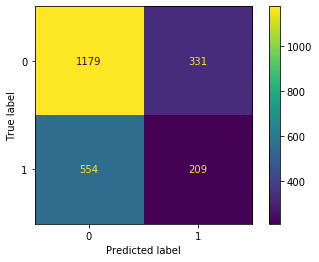

In [77]:
train_preds = nb.predict(X_train_full)
test_preds = nb.predict(X_test_full)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(nb, X_test_full, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()
# Accuracy down .1
# Precision down .2
# Big negative impact with additional features

### Data Reformat
- Convert brand and type columns to 0-1 columns to see if model reads better

In [78]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product',
       'brand_directed_at', 'num_brand_directed_at', 'type_directed_at',
       'num_type_directed_at', 'target', 'clean_text'],
      dtype='object')

In [79]:
# Create new columns for brands
df['tweet_brand_Apple'] = 0
df['tweet_brand_Google'] = 0

# Assign 1 in respective column based on brand_directed_at
for row in df['brand_directed_at'].index:
    if df['brand_directed_at'][row] == 'Apple':
        df['tweet_brand_Apple'][row] = 1
    elif df['brand_directed_at'][row] == 'Google':
        df['tweet_brand_Google'][row] = 1

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [80]:
# Do same for type_directed_at
df['tweet_type_product'] = 0
df['tweet_type_app'] = 0
df['tweet_type_brand'] = 0
df['tweet_type_service'] = 0

for row in df['type_directed_at'].index:
    if df['type_directed_at'][row] == 'Product':
        df['tweet_type_product'][row] = 1
    if df['type_directed_at'][row] == 'App':
        df['tweet_type_app'][row] = 1
    if df['type_directed_at'][row] == 'Brand':
        df['tweet_type_brand'][row] = 1
    elif df['type_directed_at'][row] == 'Service':
        df['tweet_type_service'][row] = 1

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [81]:
# Review df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 15 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       9092 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9092 non-null object
brand_directed_at                                     9092 non-null object
num_brand_directed_at                                 9092 non-null int64
type_directed_at                                      9092 non-null object
num_type_directed_at                                  9092 non-null int64
target                                                9092 non-null int64
clean_text                                            9092 non-null object
tweet_brand_Apple                                     9092 non-null int64
tweet_brand_Google                                    9092 non-null int64
tweet_type_product                                    9092 non-null int64

In [82]:
# Create new df with subset of columns for ease
NB_df = df.drop(columns=['tweet_text', 'emotion_in_tweet_is_directed_at',
               'is_there_an_emotion_directed_at_a_brand_or_product',
                'brand_directed_at', 'num_brand_directed_at',
                'type_directed_at', 'num_type_directed_at'], axis=1)

In [83]:
# Preview
NB_df.head()

,target,clean_text,tweet_brand_Apple,tweet_brand_Google,tweet_type_product,tweet_type_app,tweet_type_brand,tweet_type_service
0,0,g iphone hr tweeting dead need upgrade plugin ...,1,0,1,0,0,0
1,1,know awesome ipadiphone app youll likely appre...,1,0,0,1,0,0
2,1,wait also sale,1,0,1,0,0,0
3,0,hope year festival isnt crashy year iphone app,1,0,0,1,0,0
4,1,great stuff fri marissa mayer google tim oreil...,0,1,0,0,1,0


### Dataset creation 
TF-IDF + appending boolean brand and type fields

In [84]:
# Grabbing our inputs and target
X = NB_df.drop(columns='target', axis=1)
y = NB_df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### TF-IDF application

In [85]:
# Instantiating the TF-IDF vectorizer
tfidf3 = TfidfVectorizer(max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

In [86]:
X_train_transformed = tfidf3.fit_transform(X_train['clean_text'])
X_test_transformed = tfidf3.transform(X_test['clean_text'])

In [87]:
# Create X_train with appended columns
# X_train text vectorizing
X_train_tfidfvect_text_df = pd.DataFrame(X_train_transformed.toarray(), columns=tfidf3.get_feature_names())

In [88]:
X_train_tfidfvect_text_df.head()

,aapl,ab,abc,ability,able,absolutely,absolutley,abt,academy,acc,...,zazzle,zinio,zip,zms,zombie,zomg,zone,zoom,zuckerberg,zynga
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
# Append emotion in tweet directed at to vectorized X_train clean text
X_train_full = pd.merge(left=X_train_tfidfvect_text_df, right=X.drop(columns='clean_text', axis=1),
                        how='left', left_index=True, right_index=True)

In [90]:
# Shape check X_train
X_train_full.shape

(6819, 3715)

In [91]:
# Shape check y_train
y_train.shape

(6819,)

In [92]:
# Create X_test with appended columns
X_test_tfidfvect_text_df = pd.DataFrame(X_test_transformed.toarray(), columns=tfidf3.get_feature_names())

In [93]:
# Append emotion in tweet directed at
X_test_full = pd.concat([X.drop(columns='clean_text', axis=1), 
                        X_test_tfidfvect_text_df], axis=1, join='inner')

In [94]:
# Shape check
X_test_full.shape

(2273, 3715)

In [95]:
# Preview
X_test_full.head()

,tweet_brand_Apple,tweet_brand_Google,tweet_type_product,tweet_type_app,tweet_type_brand,tweet_type_service,aapl,ab,abc,ability,...,zazzle,zinio,zip,zms,zombie,zomg,zone,zoom,zuckerberg,zynga
0,1,0,1,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,1,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,1,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Model 5: Naive Bayes + TF-IDF<a id="Model_5"></a>
Try again with reformatted Boolean features on X

In [96]:
nb = MultinomialNB()
nb.fit(X_train_full, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Accuracy:0.5741311042674879
Precision:0.34108527131782945
F1 Score:0.31249999999999994


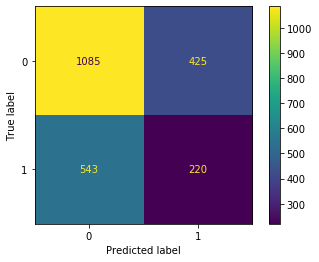

In [97]:
train_preds = nb.predict(X_train_full)
test_preds = nb.predict(X_test_full)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(nb, X_test_full, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()
# Accuracy and precision further down (.04 on both)

#### Model 6: Random Forest + TF-IDF<a id="Model_6"></a>
Switch model type. Maybe additional features not helping Naive Bayes model specifically

In [98]:
# Try RandomForest again
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train_full, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy:0.6603607567091949
Precision:0.36363636363636365
F1 Score:0.030150753768844216


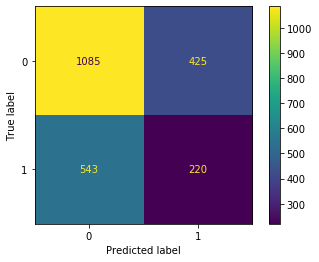

In [99]:
train_preds = rfc.predict(X_train_full)
test_preds = rfc.predict(X_test_full)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(nb, X_test_full, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()
# Better accuracy by 0.05 on best Naive Bayes with additional features
# Still below model without additional features

### Learning: 
Additional features beyond the text of the tweet are not helping this classification model.
If the formatting, parsing, and understanding of the text is most important, next step is to revisit preprocessing methods to potentially get more meaning from the tweets that will help model metrics.

# Navigate to "Preprocessing_V2.ipynb" notebook for most recent approach to this model